In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

In [2]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [3]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [4]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_18352/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [6]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [7]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,4955.453643,1122.139662
1994-01-10,3440.58,2930.333782,1080.347860
1994-01-11,3413.77,6368.652463,1082.095245
1994-01-12,3372.02,6112.516316,1083.639265
1994-01-13,3360.01,6026.011870,1067.146255


## ***ARMA Model***
- This Model Incorporate values obtained at certain previous lags and residual obatined at previous certain lag.
- The reason both are incorporated here cause moving average part will handle unexpected shocks in the price prediction
- where for given moving average prediction the auto regresion component will give a foundation to the moving average predicton to adjust itself.

> Since we know that MA and AR model perform well in stationary data So we will first check how ARMA performing in the return price.

In [16]:
df_market_value_train['return']=df_market_value_train['market_value'].pct_change(1).mul(100)
df_market_value_train=df_market_value_train[1:]

### ***ARMA(1,1) Model***

In [17]:
model_ar1_ma1=ARIMA(df_market_value_train['return'],order=(1,0,1),freq='B')
result_ar1_ma1= model_ar1_ma1.fit()
print(result_ar1_ma1.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7916.602
Date:                Fri, 25 Oct 2024   AIC                          15841.204
Time:                        12:53:04   BIC                          15867.289
Sample:                    01-10-1994   HQIC                         15850.345
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.289      0.197      -0.010       0.048
ar.L1          0.7659      0.045     17.011      0.000       0.678       0.854
ma.L1         -0.8149      0.040    -20.191      0.0

### ***Observation***
- Coefficients of ARMA model is found out to be significant.
1.  Here coefficient-1 of Autoregression part is positive it means that, there is a positive trend between past and present values.
    - Let me explain it more briefly: since we are dealing with return here(change in price in consecutve period) So if last certain period  return has positive value then it will retain this momentum in further period. thats the reason coefficient value are postive cause prediction would be also positive. it is also true for negative return, So this downward trend of the index price will tends to retains its momentum for further period.
    - It bascially says trend obtained by market tends to persist for sometimes untill and unless there change in market sentiments.

2. In other word we can says that positive AR coefficient suggest that the market will maintain its momentum/trend either in upward or downward for while.
  
3. Coefficent-1 of Moving Average is found out to be negative. Let me explain it by taking example. lets says that in last certain period the residual error is negative it means that predicted return is more than actual. so when the obtained residual in the past, is multiplied by negative coefficient will give positive value,which will increase the predicted value to minimize the residual in further period. if the residual is positive then it means that prediction is less than actual return. So positive residual multiplied with negative coefficient will give a negative value. So some value would be reduced from the prediction to reduce residual error in further period.
4. This above explained behaviour is possible when frequent positive and negative return occuar in market in cosecutive period.
5. It means that if return is positive today for some unexpected shocks then most probable it will go down in next period.
6. This is also called mean reverting behaviour.
7. And the negative MA coefficient indicate mean reversion, implying that deviation from expected price will be corrected in oposite direction.
8. Traders and investors in the FTSE market may chase trends (momentum) in the short term but also expect the market to self-correct (reversion to the mean) when it moves too far from its expected path. This reflects a balance between optimism (momentum) and caution (correction).
##### ***summary***
1. If coefficient of moving average is positive: Past positive shocks will move current return higher. And past negative shocks will move current return more lower.
2.  if coefficients of moving average is negative: It means that past positive shocks will cause current lower return and past negative shocks will increase the return 

In [18]:
def LLR_test(Model_a_res,Model_b_res,df=1):
    La=Model_a_res.llf
    Lb=Model_b_res.llf
    Q=2*(Lb-La)
    P=chi2.sf(Q,df)
    return P

#### lets compare the ARMA(1,1) model with AR(1), and MA(1) model with LLR test

In [19]:
model_ar1=ARIMA(df_market_value_train['return'],order=(1,0,0),freq='B')
result_ar1=model_ar1.fit()
print(result_ar1.summary())
print("LLR test of AR1 and ARMA(1,1)",LLR_test(result_ar1,result_ar1_ma1))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.756
Date:                Fri, 25 Oct 2024   AIC                          15865.512
Time:                        12:53:05   BIC                          15885.076
Sample:                    01-10-1994   HQIC                         15872.368
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.690      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.098      0.0

In [20]:
model_ma1=ARIMA(df_market_value_train['return'],order=(0,0,1),freq='B')
result_ma1=model_ma1.fit()
print(result_ma1.summary())
print("LLR test of MA1 and ARMA(1,1)",LLR_test(result_ma1,result_ar1_ma1))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.601
Date:                Fri, 25 Oct 2024   AIC                          15865.203
Time:                        12:53:07   BIC                          15884.766
Sample:                    01-10-1994   HQIC                         15872.058
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.013      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.997      0.0

#### ***Observation***
- By observing the above LLR test of AR(1) with ARMA(1,1) and MA(1) with ARMA(1,1) it is clear that ARMA(1,1) Model Performed well.
- So Lets start searching for better ARMA model for better likelihood estimation by help of ACF and PACF Plot.

#### PACF Plot

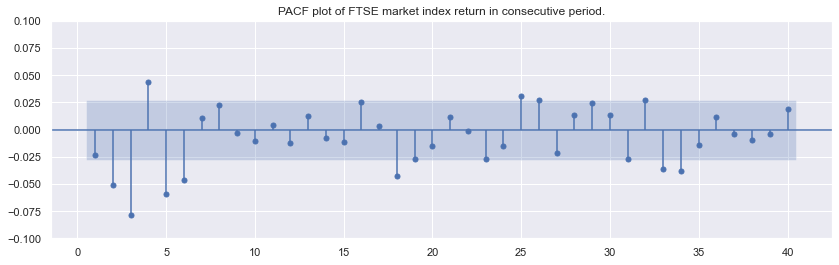

In [25]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['return'],zero=False,lags=40,method='ols')
plt.title('PACF plot of FTSE market index return in consecutive period.')
plt.ylim((-0.1,0.1))
plt.show()

#### ***ACF PLot of return***

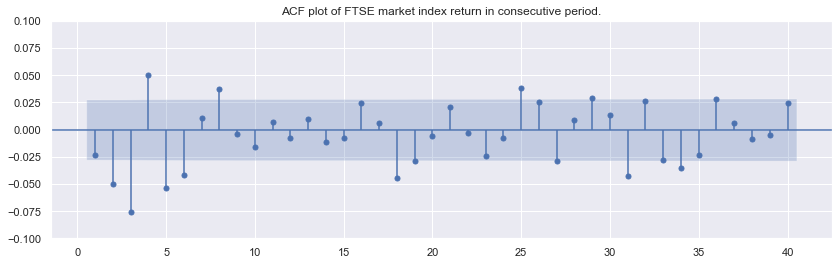

In [24]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['return'],zero=False,lags=40)
plt.title('ACF plot of FTSE market index return in consecutive period.')
plt.ylim((-0.1,0.1))
plt.show()

#### ***Observing***
-  By observing ACF and PACF Plot we can says that, for AR component lags upto 6 has significant correlaiton with current values, and for Moving average component lags upto 8 has significant correlation.
-  IN ARMA model selection we ofter start from higher lags value.
-  So we will examine performance of ARMA model from higher lags to lower (6,8)-->(1,1), to check which one is performing well.
-  We use LLR test to compare likelihood performance  of each model, where simpler one will be taken as null hypothesis.

#### ***ARMA(6,8)***

In [26]:
model_ar6_ma8=ARIMA(df_market_value_train['return'],order=(6,0,8),freq='B')
result_ar6_ma8= model_ar6_ma8.fit()
print(result_ar6_ma8.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(6, 0, 8)   Log Likelihood               -7882.884
Date:                Fri, 25 Oct 2024   AIC                          15797.768
Time:                        13:19:41   BIC                          15902.107
Sample:                    01-10-1994   HQIC                         15834.329
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.308      0.191      -0.009       0.047
ar.L1         -0.5049      0.163     -3.101      0.002      -0.824      -0.186
ar.L2         -0.4796      0.152     -3.158      0.0

#### ***Observation***
- significance of all the coefficient values of ar and ma component are good compared to value zero.
- But onething to observe here that the corresponding coefficients of AR component and MA componet at certain lag have oposite sign.
- It means that most of time it will cancel each other.
- So for sake simplicity and to reduce unnecessary computation we will less lag values.
- Lets compare the model with ARMA(6,6), ARMA(5,5), ARMA(4,4), ARMA(3,3).
- Also the reason why it should work cause current adjustment and prediction does not really rely on past residual or value that happend long before cause market sentiments depends upon current news and momentum obtain in last certain period.

In [27]:
model_ar6_ma6=ARIMA(df_market_value_train['return'],order=(6,0,6),freq='B')
result_ar6_ma6= model_ar6_ma6.fit()
print(result_ar6_ma6.summary())
print('LLR Test of Model_ar6_ma8 and Model_ar6_ma6',LLR_test(result_ar6_ma6,result_ar6_ma8))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(6, 0, 6)   Log Likelihood               -7884.059
Date:                Fri, 25 Oct 2024   AIC                          15796.119
Time:                        13:36:30   BIC                          15887.415
Sample:                    01-10-1994   HQIC                         15828.110
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.306      0.191      -0.010       0.049
ar.L1         -0.5519      2.927     -0.189      0.850      -6.288       5.185
ar.L2         -0.5967      0.121     -4.950      0.0

#### ***Observation***
- Most of the coefficient of ARMA(6,6) has insignificant values. and whole model performance doesnot differ much from ARMA(6,8) So we will reject this model.

In [30]:
model_ar5_ma5=ARIMA(df_market_value_train['return'],order=(5,0,5),freq='B')
result_ar5_ma5= model_ar5_ma5.fit()
print(result_ar5_ma5.summary())
print('LLR Test of Model_ar5_ma5 and Model_ar6_ma8',LLR_test(result_ar5_ma5,result_ar6_ma8))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7884.275
Date:                Fri, 25 Oct 2024   AIC                          15792.549
Time:                        14:23:59   BIC                          15870.803
Sample:                    01-10-1994   HQIC                         15819.970
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.015      1.436      0.151      -0.008       0.050
ar.L1         -0.0452      0.116     -0.391      0.696      -0.272       0.182
ar.L2         -0.5533      0.079     -7.022      0.0

#### ***Observation***
- Model ARMA(5,5) has also 5 no of insignificant coefficients So we will reject this model.

#### ***ARMA(3,3)***

In [32]:
model_ar3_ma3=ARIMA(df_market_value_train['return'],order=(3,0,3),freq='B')
result_ar3_ma3= model_ar3_ma3.fit()
print(result_ar3_ma3.summary())
print('LLR Test of Model_ar3_ma3 and Model_ar6_ma8',LLR_test(result_ar3_ma3,result_ar6_ma8))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7895.108
Date:                Fri, 25 Oct 2024   AIC                          15806.215
Time:                        14:24:45   BIC                          15858.385
Sample:                    01-10-1994   HQIC                         15824.496
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.285      0.199      -0.010       0.048
ar.L1         -0.1707      0.069     -2.479      0.013      -0.306      -0.036
ar.L2         -0.2956      0.054     -5.440      0.0

#### ***Observation***
- All cofficient of ARMA(3,3) are significant. and incompared to ARMA(6,8), this model has performed significantly differently.
- Since ARMA(6,8) has total 14 no of lags so it can be computationaly expensive, so we will chose ARMA(3,3) further comparision.

#### ***ARMA(3,2)***

In [33]:
model_ar3_ma2=ARIMA(df_market_value_train['return'],order=(3,0,2),freq='B')
result_ar3_ma2= model_ar3_ma2.fit()
print(result_ar3_ma2.summary())
print('LLR Test of Model_ar3_ma2 and Model_ar3_ma3',LLR_test(result_ar3_ma2,result_ar3_ma3))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7897.575
Date:                Fri, 25 Oct 2024   AIC                          15809.151
Time:                        14:33:42   BIC                          15854.799
Sample:                    01-10-1994   HQIC                         15825.146
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.210      0.226      -0.012       0.049
ar.L1         -0.6675      0.056    -11.893      0.000      -0.777      -0.557
ar.L2         -0.5190      0.064     -8.093      0.0

In [42]:
def ModelComparision(mod_1_res,mod_2_res):
    print(f"loglikelihood Model 1:\t{mod_1_res.llf},\t AIC of Model 1:\t{mod_1_res.aic}")
    print(f"loglikelihood Model 2:\t{mod_2_res.llf},\t AIC of Model 2:\t{mod_2_res.aic}")
    

In [44]:
ModelComparision(mod_1_res=result_ar3_ma2,mod_2_res=result_ar3_ma3)

loglikelihood Model 1:	-7897.575322532148,	 AIC of Model 1:	15809.150645064296
loglikelihood Model 2:	-7895.107724227526,	 AIC of Model 2:	15806.215448455052


#### ***Observation***
- By comparing the log likelihood of ARMA(3,2) AND ARMA(3,3), it is observed that both perform significantly differnt and model ARMA(3,2) perform well in term loglikelihood and aic criteriion.

### ***ARMA(2,3)***

In [45]:
model_ar2_ma3=ARIMA(df_market_value_train['return'],order=(2,0,3),freq='B')
result_ar2_ma3= model_ar2_ma3.fit()
print(result_ar2_ma3.summary())
print('LLR Test of Model_ar2_ma3 and Model_ar3_ma3',LLR_test(result_ar2_ma3,result_ar3_ma3))
ModelComparision(mod_1_res=result_ar2_ma3,mod_2_res=result_ar3_ma3)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7897.417
Date:                Fri, 25 Oct 2024   AIC                          15808.834
Time:                        14:51:36   BIC                          15854.482
Sample:                    01-10-1994   HQIC                         15824.830
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.015      1.221      0.222      -0.011       0.049
ar.L1         -0.5532      0.058     -9.525      0.000      -0.667      -0.439
ar.L2         -0.4378      0.066     -6.616      0.0

#### ***Observation***
- The model ARMA(2,3) has performed significantly different from ARMA(3,3).
- As per the loglikelihood value and AIC value MODEL ARMA(3,3) has performed well.

#### Note:
- Since in comparsion to ARMA(3,3), the model ARMA(2,3) AND ARMA(3,2) has performed significantly poorly.
- But lets see which one is better among ARMA(2,3) AND ARMA(3,2)

In [47]:
ModelComparision(mod_1_res=result_ar2_ma3,mod_2_res=result_ar3_ma2)

loglikelihood Model 1:	-7897.41708936452,	 AIC of Model 1:	15808.83417872904
loglikelihood Model 2:	-7897.575322532148,	 AIC of Model 2:	15809.150645064296


#### Observaton
- Model ARMA(2,3) has performed well by the basis of log likelihood and aic score

#### ***ARMA(2,2)***

In [46]:
model_ar2_ma2=ARIMA(df_market_value_train['return'],order=(2,0,2),freq='B')
result_ar2_ma2= model_ar2_ma2.fit()
print(result_ar2_ma2.summary())
print('LLR Test of Model_ar2_ma2 and Model_ar3_ma3',LLR_test(result_ar2_ma2,result_ar3_ma3))
ModelComparision(mod_1_res=result_ar2_ma2,mod_2_res=result_ar3_ma3)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7915.018
Date:                Fri, 25 Oct 2024   AIC                          15842.036
Time:                        14:59:58   BIC                          15881.163
Sample:                    01-10-1994   HQIC                         15855.746
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.288      0.198      -0.010       0.048
ar.L1         -0.1027      0.092     -1.114      0.265      -0.283       0.078
ar.L2          0.7008      0.068     10.349      0.0

In [48]:
ModelComparision(mod_1_res=result_ar2_ma2,mod_2_res=result_ar2_ma3)

loglikelihood Model 1:	-7915.017904910663,	 AIC of Model 1:	15842.035809821326
loglikelihood Model 2:	-7897.41708936452,	 AIC of Model 2:	15808.83417872904


### ***Observation***
- Model ARMA(2,2) has performed significantly different form ARMA(3,3) in terms of loglikelihood and AIC Score.
- but since out of 4 coefficients 2 coefficient are insignificantly different from zero so we will reject this model. since it is inconsitent.

#### NOTE:
- So till now these are the model which has perfored well. And these are written increseing order of their potential.
- ARMA(2,3) --> ARMA(3,3) --> ARMA(6,8)

#### ***ARMA(1,2)***

In [49]:
model_ar1_ma2=ARIMA(df_market_value_train['return'],order=(1,0,2),freq='B')
result_ar1_ma2= model_ar1_ma2.fit()
print(result_ar1_ma2.summary())
print('LLR Test of Model_ar1_ma2 and Model_ar2_ma3',LLR_test(result_ar1_ma2,result_ar2_ma3))
ModelComparision(mod_1_res=result_ar1_ma2,mod_2_res=result_ar2_ma3)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -7913.797
Date:                Fri, 25 Oct 2024   AIC                          15837.593
Time:                        15:27:37   BIC                          15870.199
Sample:                    01-10-1994   HQIC                         15849.019
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.283      0.200      -0.010       0.048
ar.L1          0.6166      0.065      9.559      0.000       0.490       0.743
ma.L1         -0.6465      0.064    -10.102      0.0

#### ***Observation***
- ARMA(1,2) also has performed significantly from ARMA(2,3). and loglikelihood and aic score says that model ARMA(2,3) is better.
- Since all coefficient are significant so for simplicity we can consider the model.

#### ***ARMA(2,1)***

In [50]:
model_ar2_ma1=ARIMA(df_market_value_train['return'],order=(2,0,1),freq='B')
result_ar2_ma1= model_ar2_ma1.fit()
print(result_ar2_ma1.summary())
print('LLR Test of Model_ar2_ma1 and Model_ar2_ma3',LLR_test(result_ar2_ma1,result_ar2_ma3))
ModelComparision(mod_1_res=result_ar2_ma1,mod_2_res=result_ar2_ma3)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7913.603
Date:                Fri, 25 Oct 2024   AIC                          15837.206
Time:                        15:35:05   BIC                          15869.812
Sample:                    01-10-1994   HQIC                         15848.632
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ar.L1          0.6550      0.058     11.331      0.000       0.542       0.768
ar.L2         -0.0430      0.010     -4.351      0.0

### ***Observation***
- Performance of ARMA(2,1) is compared to ARMA(2,3), evident from loglikelihood and Aic value comparison.
- all the coefficient value are also significant.
- So will consider this model for simplicity.


#### NOTE
- lets compare ARMA(1,2) AND ARMA(2,1) to chose better among them.

In [51]:
ModelComparision(mod_1_res=result_ar2_ma1,mod_2_res=result_ar1_ma2)

loglikelihood Model 1:	-7913.603059600324,	 AIC of Model 1:	15837.206119200648
loglikelihood Model 2:	-7913.796558450185,	 AIC of Model 2:	15837.59311690037


#### Ovservation
- Model ARMA(2,1) performed well in terms of Aic and log likelihood value.
- So till now better model found are.
- ARMA(1,1)--> ARMA(2,1)-->ARMA(2,3)--> ARMA(3,3)-->ARMA(6,8)
- The performance of each model has significant different from each other. hiher the number of parameter higher the performance interms of loglikelihood and Aic.
- So we want more accuracy we will chose model like ARMA(3,3) AND ARMA(6,8). but these is risk of choosing higher model as they overfit with training data.

## Lets analyze the residual obtained from Model like ARMA(3,3) AND ARMA(6,8) AND ARMA(1,1)

In [52]:
df_market_value_train.shape

(5020, 4)

In [53]:
result_ar3_ma3.resid.shape

(5020,)

#### Analysis of ARMA(1,1)

In [54]:
df_market_value_train['resid_ar1_ma1']=result_ar1_ma1.resid

In [55]:
adfuller(df_market_value_train.resid_ar1_ma1)

(-12.495321452641095,
 2.884799765867058e-23,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15700.488839594873)

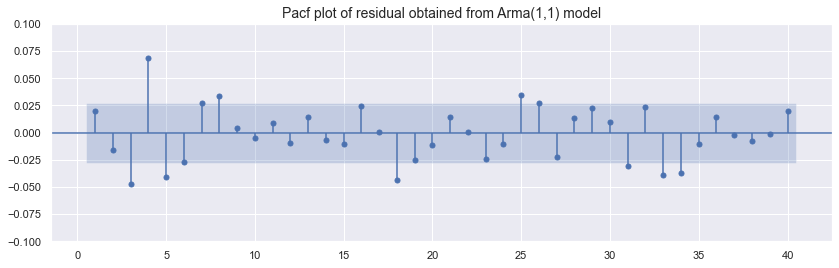

In [60]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar1_ma1'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(1,1) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

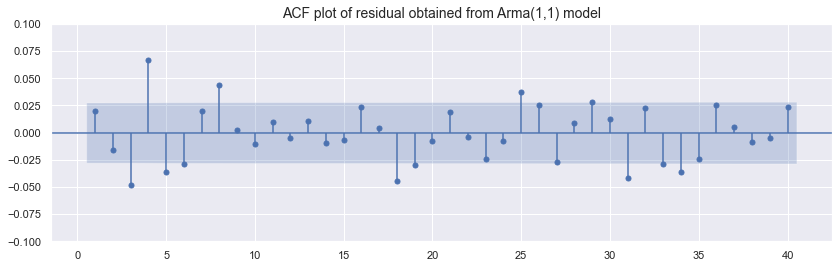

In [61]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar1_ma1'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(1,1) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

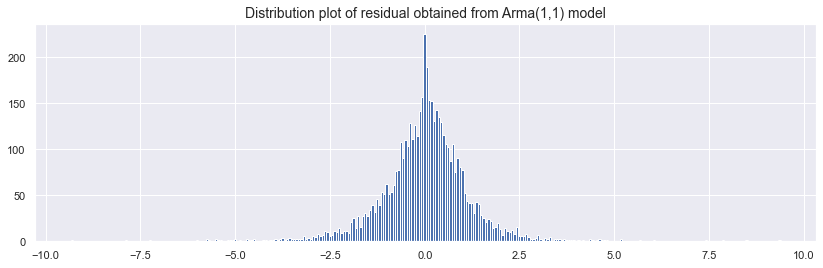

In [63]:
plt.rc('figure',figsize=(14,4))
plt.hist(df_market_value_train['resid_ar1_ma1'],bins=300)
plt.title('Distribution plot of residual obtained from Arma(1,1) model',size=14)
plt.show()

#### Observation
- By observing the residual of the ARMA(1,1) Model, it is clear that the residual are staionary.
- But by observing the acf and pacf plot, It is observed that there are still significant correlation exist between current residual and residual obtained certain lass ago. So we can't say that it is a white noice.
- So it is the evident that there still exist hidden pattern that has not been learned by model yet.
- So lets considered higher lag incorporated model. 

#### ***Residual obtained by ARMA(2,1)***

In [64]:
df_market_value_train['resid_ar2_ma1']=result_ar2_ma1.resid

In [65]:
adfuller(df_market_value_train.resid_ar2_ma1)

(-12.661924501637356,
 1.2993210286102342e-23,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15700.808219200177)

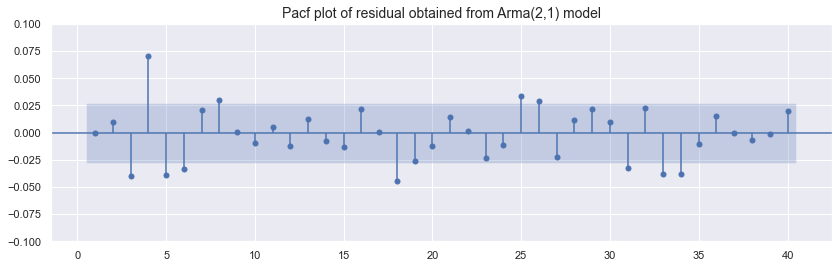

In [66]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar2_ma1'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(2,1) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

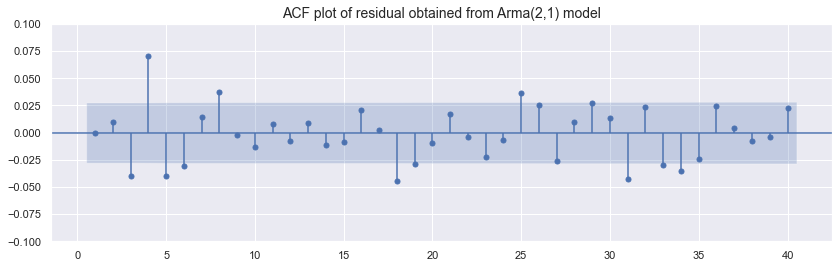

In [67]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar2_ma1'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(2,1) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

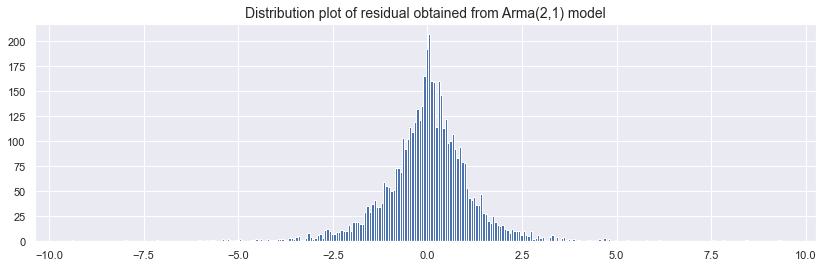

In [68]:
plt.rc('figure',figsize=(14,4))
plt.hist(df_market_value_train['resid_ar2_ma1'],bins=300)
plt.title('Distribution plot of residual obtained from Arma(2,1) model',size=14)
plt.show()

#### ***Observation***
- Model ARMA also unable to learn all the pattern the past data to prdict furture accurately since It is evident from the pacf and acf plot of residuals.
- there still some significant correlation exist.
- So lets incorporate higer lags like (3,3). Since ARMA(3,3) has performed well in comparison to others low lags model so it would be better to use this. Another reason why we should not use model liek (5,5) or (4,4) cause thier coefficient are very inconsistent and has Insignificant values from zero.

#### analysis of residuals of ARMA(3,3)

In [69]:
df_market_value_train['resid_ar3_ma3']=result_ar3_ma3.resid

In [72]:
adfuller(df_market_value_train.resid_ar3_ma3)


(-12.661460039555712,
 1.3021861972718558e-23,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15701.568702418588)

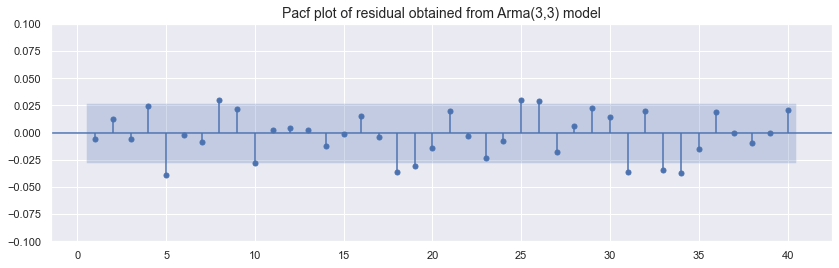

In [73]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar3_ma3'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(3,3) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

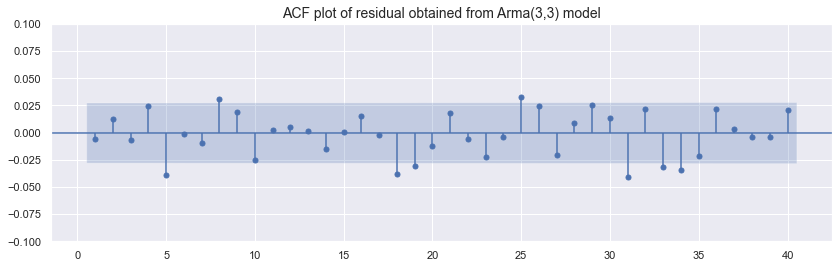

In [74]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar3_ma3'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(3,3) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

#### ***Observation***
- Residual are stationary as per adfuller test but a significant correlation still exist between value at lags-5 so some further searching of model is required.
- Lets investigate model ARMA with parameter (5,5).

In [75]:
df_market_value_train['resid_ar5_ma5']=result_ar5_ma5.resid
adfuller(df_market_value_train.resid_ar5_ma5)

(-70.87863757762717,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15686.9400145511)

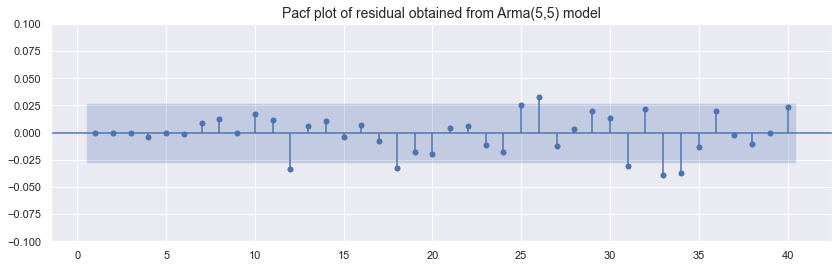

In [76]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar5_ma5'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(5,5) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

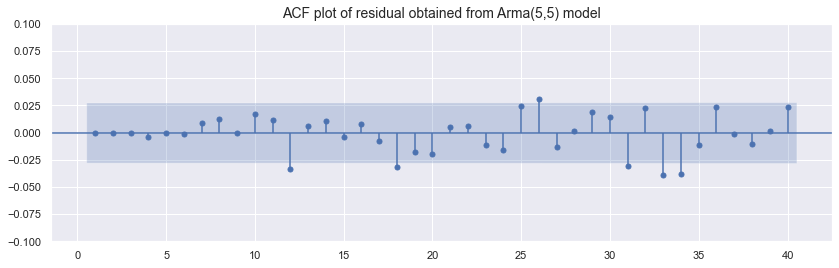

In [77]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar5_ma5'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(5,5) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

In [79]:
print(result_ar5_ma5.summary())

                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7884.275
Date:                Fri, 25 Oct 2024   AIC                          15792.549
Time:                        20:11:31   BIC                          15870.803
Sample:                    01-10-1994   HQIC                         15819.970
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.015      1.436      0.151      -0.008       0.050
ar.L1         -0.0452      0.116     -0.391      0.696      -0.272       0.182
ar.L2         -0.5533      0.079     -7.022      0.0

#### ***Observation***
- Residual obtained from the ARMA(5,5) has significant evidence that it is not stationary as per adfuller test.
- And it is also nice that there is not significant correlation exist between current residual and residual before certains lags, except certain coincidental correlation.
- But significant of all the coefficients are not significant from zero os it is inconsistent.
- So lets check is there any other model exist for which will get better model than ARMA(3,3) and all the coefficients are significant.

### ARMA(5,4)

In [82]:
model_ar5_ma4=ARIMA(df_market_value_train['return'],order=(5,0,4),freq='B')
result_ar5_ma4= model_ar5_ma4.fit()
print(result_ar5_ma4.summary())
print('LLR Test of Model_ar3_ma3 and Model_ar5_ma4',LLR_test(result_ar3_ma3,result_ar5_ma4))
ModelComparision(mod_1_res=result_ar3_ma3,mod_2_res=result_ar5_ma4)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -7884.938
Date:                Fri, 25 Oct 2024   AIC                          15791.875
Time:                        20:21:46   BIC                          15863.608
Sample:                    01-10-1994   HQIC                         15817.011
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1          0.1397      0.083      1.686      0.092      -0.023       0.302
ar.L2         -0.5970      0.081     -7.344      0.0

In [84]:
df_market_value_train['resid_ar5_ma4']=result_ar5_ma4.resid
adfuller(df_market_value_train.resid_ar5_ma4)

(-70.77431832112477,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15688.388334715142)

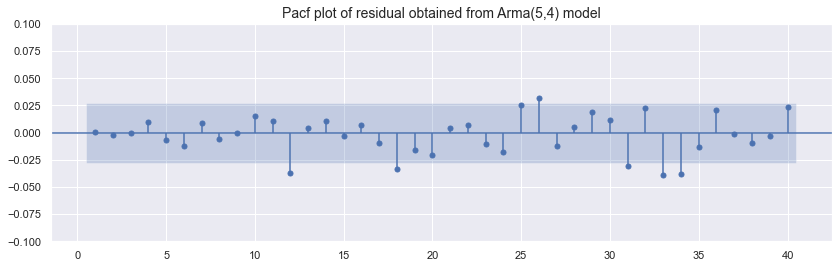

In [85]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar5_ma4'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(5,4) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

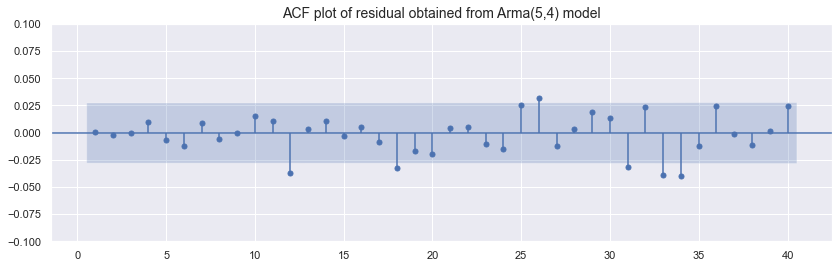

In [86]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar5_ma4'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(5,4) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

### ***Observation***
- The Model Arma(5,4) has performed well incomparion to ARMA(5,5) AND ARMA(3,3), since all the coefficients are significant excepts 3 coeffients out of 9.
- IN term of loglikelihood ratio test also model has performed well.
- In term corelation of residual also we can not find significant correlation.
- but since ther still some insignificant coefficient exist so we will prefer to find better model.

### ARMA(5,3)


In [87]:
model_ar5_ma3=ARIMA(df_market_value_train['return'],order=(5,0,3),freq='B')
result_ar5_ma3= model_ar5_ma3.fit()
print(result_ar5_ma3.summary())
print('LLR Test of Model_ar3_ma3 and Model_ar5_ma3',LLR_test(result_ar3_ma3,result_ar5_ma3))
ModelComparision(mod_1_res=result_ar3_ma3,mod_2_res=result_ar5_ma3)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -7886.848
Date:                Fri, 25 Oct 2024   AIC                          15793.697
Time:                        20:33:18   BIC                          15858.908
Sample:                    01-10-1994   HQIC                         15816.548
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.278      0.201      -0.010       0.048
ar.L1          0.3355      0.081      4.160      0.000       0.177       0.494
ar.L2         -0.5197      0.073     -7.096      0.0

In [88]:
df_market_value_train['resid_ar5_ma3']=result_ar5_ma3.resid
adfuller(df_market_value_train.resid_ar5_ma3)

(-70.81229061699698,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.281902211447)

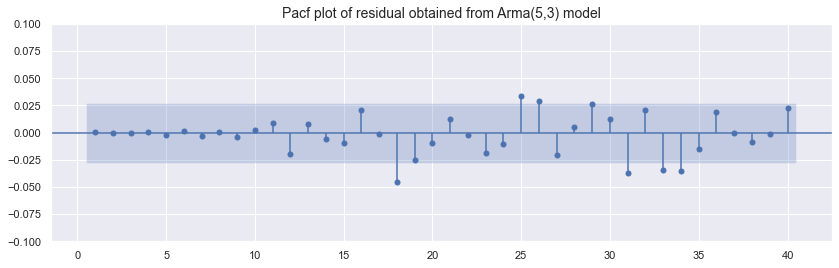

In [89]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar5_ma3'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(5,3) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

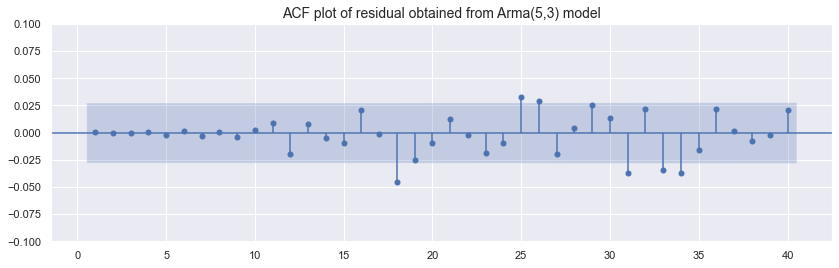

In [90]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar5_ma3'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(5,3) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

### ***Observation***
- Eventhough the model ARMA(5,3) has performed significantly well in term of Log likelyhood, Aic and LLR test still it has 2 insignificant coefficients.
- The model performed well in learning pattern from past data aswell which evident from the acf and pacf plot of residual obtained from this very model.
- So we should further search for the better model than ARMA(3,3).

### ***ARMA(5,2)***

In [91]:
model_ar5_ma2=ARIMA(df_market_value_train['return'],order=(5,0,2),freq='B')
result_ar5_ma2= model_ar5_ma2.fit()
print(result_ar5_ma2.summary())
print('LLR Test of Model_ar3_ma3 and Model_ar5_ma2',LLR_test(result_ar3_ma3,result_ar5_ma2))
ModelComparision(mod_1_res=result_ar3_ma3,mod_2_res=result_ar5_ma2)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 2)   Log Likelihood               -7887.125
Date:                Fri, 25 Oct 2024   AIC                          15792.251
Time:                        20:43:59   BIC                          15850.941
Sample:                    01-10-1994   HQIC                         15812.817
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.284      0.199      -0.010       0.048
ar.L1          0.2823      0.076      3.690      0.000       0.132       0.432
ar.L2         -0.5093      0.074     -6.865      0.0

In [92]:
df_market_value_train['resid_ar5_ma2']=result_ar5_ma2.resid
adfuller(df_market_value_train.resid_ar5_ma2)

(-70.86428848616983,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.779672247878)

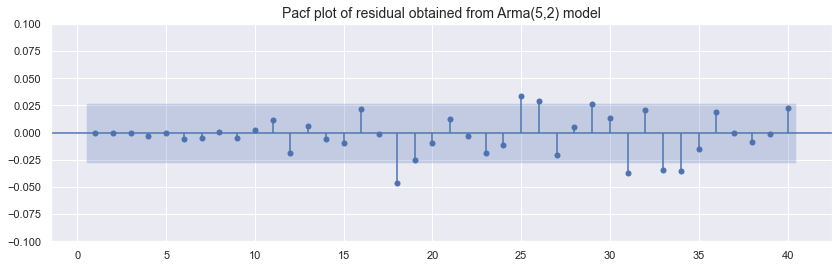

In [93]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['resid_ar5_ma2'],method='ols',lags=40,zero=False)
plt.title('Pacf plot of residual obtained from Arma(5,2) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

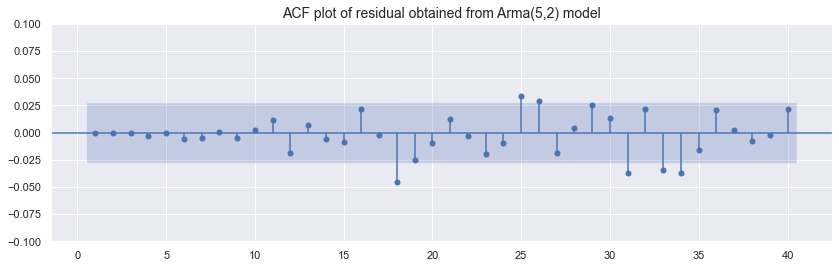

In [94]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train['resid_ar5_ma2'],lags=40,zero=False)
plt.title('ACF plot of residual obtained from Arma(5,2) model',size=14)
plt.ylim((-0.10,0.10))
plt.show()

In [106]:
mean,std=df_market_value_train['resid_ar5_ma2'].mean(),df_market_value_train.resid_ar5_ma2.std()
mean,std

(-4.336226129087251e-05, 1.1645073383305116)

In [107]:
ci=norm.interval(alpha=0.997,loc=mean,scale=std)
ci

(-3.4559959545635657, 3.45590923004097)

#### ***Observation and Conclusion***
- By observing the summary statitics of ARMA(5,2), it is clear that the model has all coefficients significant from zero.
- LLR test shown that model has performed significantly better than ARMA(3,3).
- In LLF and Aic score are better.
- By analyzing the residual it is observed that the residual obtained is stationary as per the adfullter test.
- Has zero number significant correlation between current residuals and residual obtained at previous lags except some coincidence, which is evident form pacf and acf plot form above.
- So this residual can ba considered as white noice, which must normal distribution.
- mean of this white noice is -4.33...e-05 and std is 1.164
#### conclusion
- Model ARMA(5,2) has selected as best predictor of future return.
- 99.7 % confidence interval of expected error found out to be between (-3.4559,+3.45590).
- So the invester should be able to take risk of -3.45% with probabilty of 99.7% , if they are relying on this model.